In [131]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 75
num_words_description = 75
directory_prefix = "../"
label_depth = 3
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords


import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
#embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
#print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    #words = list(filter(lambda w: len(w)>2, words))
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    #print(ret.shape)
    return ret
 
with open(directory_prefix+"/class_descriptions/class_descriptions_multi_patents.pickle", 'rb') as f:
    pre_label_dict = pickle.load(f)


class LabelDict():
    def __init__(self):
        self.store = {}
    def __getitem__(self, key):
        #print(len(self.store[key]))
        return random.choice(self.store[key])
        
    def __setitem__(self, key, value):
        if key in self.store.keys():
            self.store[key].extend(value)
        else:
            self.store[key] = value
    
    def keys(self):
        return self.store.keys()
    def __len__(self):
        return len(self.store)

label_dict = LabelDict()
for k, val in pre_label_dict.items():
    if(len(pre_label_dict[k]) == 0):
        continue
    label_dict[k[:label_depth]] = [get_sentence_vector(i.lower(), num_words_description) for i in pre_label_dict[k][:10]]

#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())
print(label_dict_keys)

{'A62', 'H02', 'D05', 'C11', 'H04', 'A46', 'G03', 'A43', 'B05', 'F16', 'G05', 'A42', 'G04', 'B24', 'B81', 'F21', 'F24', 'A23', 'E05', 'A01', 'B66', 'F03', 'B07', 'E06', 'A21', 'C01', 'C30', 'C09', 'H01', 'F15', 'C07', 'G09', 'B60', 'B29', 'H03', 'B44', 'B63', 'A44', 'D02', 'F42', 'B32', 'D06', 'C13', 'B26', 'A61', 'G21', 'B82', 'C22', 'F26', 'B41', 'C06', 'B61', 'B27', 'B08', 'E03', 'B28', 'B25', 'B64', 'B31', 'A22', 'B67', 'G01', 'G06', 'C25', 'C03', 'B22', 'F01', 'E01', 'C02', 'B21', 'B03', 'A24', 'B42', 'E02', 'D07', 'B02', 'C10', 'C21', 'A47', 'C04', 'F04', 'G08', 'D03', 'F02', 'F41', 'F25', 'F17', 'F22', 'F28', 'G10', 'B06', 'Y10', 'A41', 'B23', 'Y02', 'G16', 'F23', 'C05', 'G07', 'A45', 'G11', 'A63', 'H05', 'Y04', 'B68', 'B33', 'G02', 'B30', 'D21', 'B65', 'C23', 'B04', 'F05', 'E21', 'D04', 'B43', 'B01', 'B09', 'B62', 'F27', 'C08', 'E04', 'C14', 'C12', 'D01'}


In [138]:
print(label_dict["C08"])

tf.Tensor(
[[ 0.03290212  0.08992191 -0.00915791 ... -0.01685938 -0.10722967
   0.08288833]
 [ 0.00355855  0.10080713 -0.17192775 ... -0.08860517  0.03498135
   0.07510405]
 [-0.12412417 -0.06748357 -0.12567487 ... -0.14281765 -0.04497379
  -0.09225348]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(75, 128), dtype=float32)


In [140]:
def lstm_data_generator():
    current_dataframe = pd.read_csv(directory_prefix+'datasets/items2.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(len(current_dataframe), len(current_dataframe)//2)
    for row in current_dataframe[indices]:
        label, description=row[0], row[1]
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = [label_dict[i] for i in random.sample(label_dict_keys, min(1*len(label_vectors), len(label_dict.keys()))) if i not in label_vectors]
        for l in (label_dict[i] for i in label_vectors):
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l in non_true_vectors:
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(16, drop_remainder=True).prefetch(100).repeat()
           

In [141]:


input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

patent_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = embedding_dim*2
patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(patent_mask)
label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(label_mask)

#


patent = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(patent)
patent = tf.keras.layers.GlobalAveragePooling1D()(patent)

label = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(label)
label = tf.keras.layers.GlobalAveragePooling1D()(label)
#patent = tf.keras.layers.Dense(layer_size//2)(patent)
#label =  tf.keras.layers.Dense(layer_size//2)(label)

#subtract = tf.keras.layers.Subtract()([patent, label])
#multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [125]:
print(len(label_dict))

573


In [142]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    model.load_weights(directory_prefix+"checkpoints/doublelstmcheckpoint2.h5")
except:
    pass

model.summary()
opt = tf.optimizers.Adam(1e-5)
model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"checkpoints/doublelstmcheckpoint1.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 128)]    0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75, 128)]    0                                            
__________________________________________________________________________________________________
masking_11 (Masking)            (None, 75, 128)      0           input_2[0][0]                    
__________________________________________________________________________________________________
masking_10 (Masking)            (None, 75, 128)      0           input_1[0][0]                    
______________________________________________________________________________________

In [143]:
label_len = len(label_dict_keys)
left_vectors = np.array(list(label_dict.keys())).reshape((label_len))
recalls = np.arange(0, 1.01, .01)
def get_n(prediction, label_vectors):
    indices = np.flip(np.argsort(prediction, axis=0)).reshape((label_len))
    #print(left_vectors[indices])
    e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
    cur = []
    total_ones = e.count(1)
    n = 0
    ones_seen = 0
    while ones_seen < total_ones:
        if e[n] == 1:
            ones_seen = ones_seen+1
        n = n+1
        cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
    new_cur = []
    for r in recalls:
        max_of_larger = max([i[0] for i in cur if i[1] >= r])
        new_cur.append(max_of_larger)
    return new_cur

def generate_prc():
    #print(label_len)
    left = np.vstack([label_dict[i] for i in label_dict_keys]).reshape((label_len, num_words_description, embedding_dim))
    num_tests = 100
    ns = []
    k = 0
    for row in pd.read_csv(directory_prefix+'datasets/items2.csv',sep=',', header = None).to_numpy()[:num_tests]:
        #print(k)
        k+=1
        label, description=row[0], row[1]
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        if label_vectors == set():
            continue
        lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
        output = np.vstack([lstm_input_patent]*label_len)
        output = output.reshape((label_len, num_words, embedding_dim))
        #print(output.shape)
        #output = np.broadcast_to(lstm_input_patent, (label_len, lstm_input_patent.shape[0], lstm_input_patent.shape[1]))
        #print(output.shape, left.shape)
        prediction = model.predict({"input_1":output, "input_2":left}, verbose=0)
        #print(prediction.shape)
        n = get_n(prediction, label_vectors)
        ns.append(n)
        
    p = np.mean(np.array(ns), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')
import time

start = time.time()
#generate_prc()
end = time.time()
print(end - start)


1.71661376953125e-05


Epoch 1/50
5444/5444 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5957
Epoch 00001: saving model to ../checkpoints/doublelstmcheckpoint1.h5


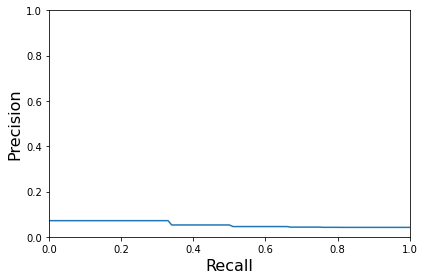

5444/5444 [==============================] - 233s 43ms/step - loss: 0.6916 - accuracy: 0.5957
Epoch 2/50
5444/5444 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6634
Epoch 00002: saving model to ../checkpoints/doublelstmcheckpoint1.h5


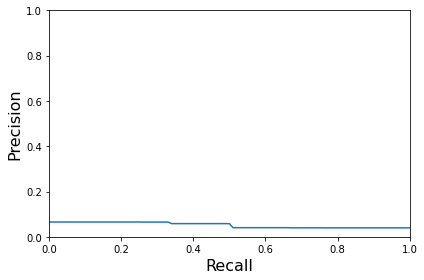

5444/5444 [==============================] - 225s 41ms/step - loss: 0.6090 - accuracy: 0.6634
Epoch 3/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.6806
Epoch 00003: saving model to ../checkpoints/doublelstmcheckpoint1.h5


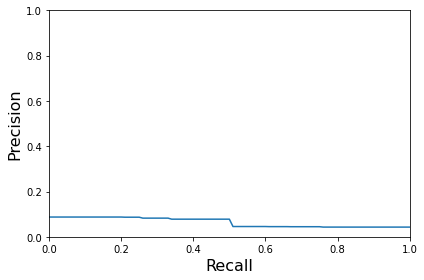

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5918 - accuracy: 0.6806
Epoch 4/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.6922
Epoch 00004: saving model to ../checkpoints/doublelstmcheckpoint1.h5


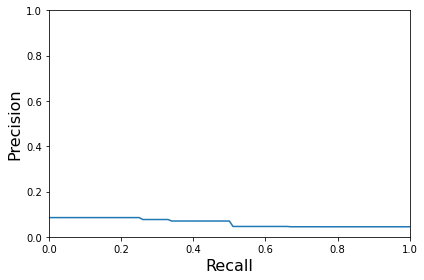

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5797 - accuracy: 0.6922
Epoch 5/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5692 - accuracy: 0.7012
Epoch 00005: saving model to ../checkpoints/doublelstmcheckpoint1.h5


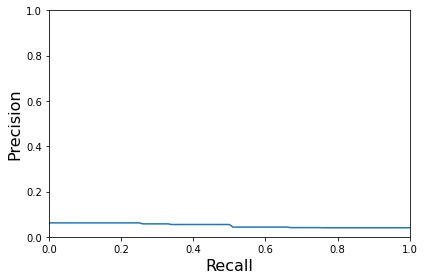

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5692 - accuracy: 0.7012
Epoch 6/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7093
Epoch 00006: saving model to ../checkpoints/doublelstmcheckpoint1.h5


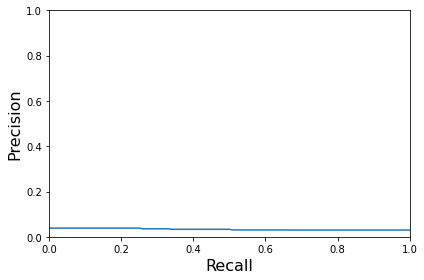

5444/5444 [==============================] - 227s 42ms/step - loss: 0.5621 - accuracy: 0.7093
Epoch 7/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5582 - accuracy: 0.7115
Epoch 00007: saving model to ../checkpoints/doublelstmcheckpoint1.h5


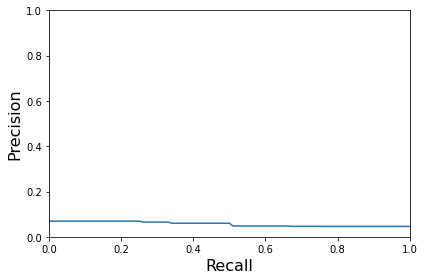

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5582 - accuracy: 0.7115
Epoch 8/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5515 - accuracy: 0.7167
Epoch 00008: saving model to ../checkpoints/doublelstmcheckpoint1.h5


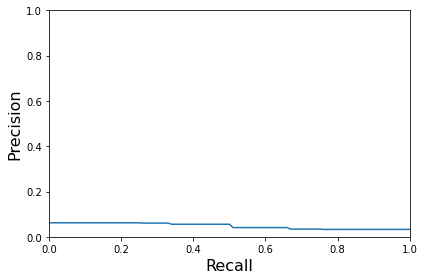

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5516 - accuracy: 0.7166
Epoch 9/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7205
Epoch 00009: saving model to ../checkpoints/doublelstmcheckpoint1.h5


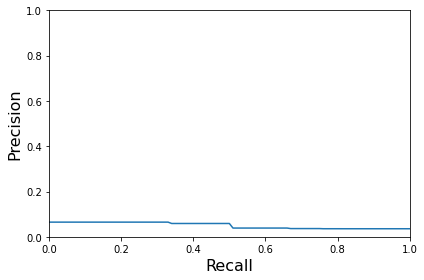

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5477 - accuracy: 0.7205
Epoch 10/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7209
Epoch 00010: saving model to ../checkpoints/doublelstmcheckpoint1.h5


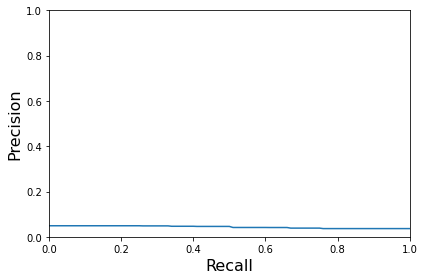

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5436 - accuracy: 0.7209
Epoch 11/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7299
Epoch 00011: saving model to ../checkpoints/doublelstmcheckpoint1.h5


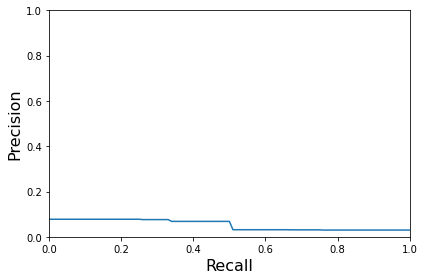

5444/5444 [==============================] - 227s 42ms/step - loss: 0.5384 - accuracy: 0.7299
Epoch 12/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.7310
Epoch 00012: saving model to ../checkpoints/doublelstmcheckpoint1.h5


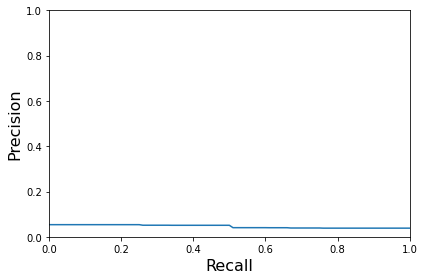

5444/5444 [==============================] - 226s 41ms/step - loss: 0.5344 - accuracy: 0.7310
Epoch 13/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.7348
Epoch 00013: saving model to ../checkpoints/doublelstmcheckpoint1.h5


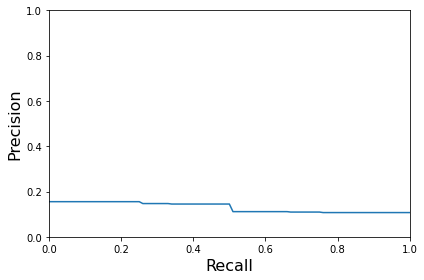

5444/5444 [==============================] - 226s 41ms/step - loss: 0.5292 - accuracy: 0.7348
Epoch 14/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.7400
Epoch 00014: saving model to ../checkpoints/doublelstmcheckpoint1.h5


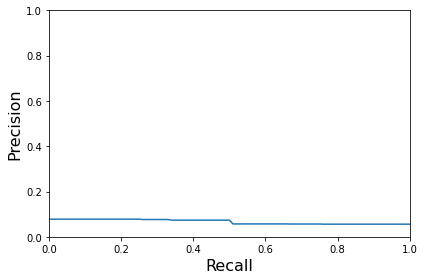

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5262 - accuracy: 0.7400
Epoch 15/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5223 - accuracy: 0.7415
Epoch 00015: saving model to ../checkpoints/doublelstmcheckpoint1.h5


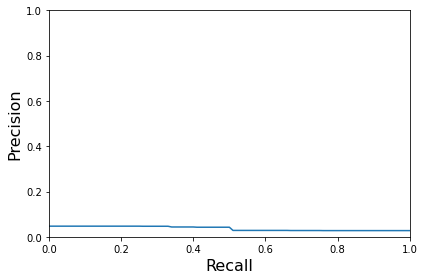

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5225 - accuracy: 0.7415
Epoch 16/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7466
Epoch 00016: saving model to ../checkpoints/doublelstmcheckpoint1.h5


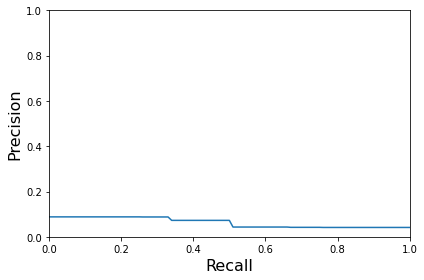

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5170 - accuracy: 0.7466
Epoch 17/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7489
Epoch 00017: saving model to ../checkpoints/doublelstmcheckpoint1.h5


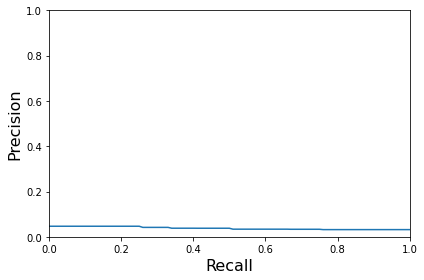

5444/5444 [==============================] - 226s 42ms/step - loss: 0.5130 - accuracy: 0.7489
Epoch 18/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7558
Epoch 00018: saving model to ../checkpoints/doublelstmcheckpoint1.h5


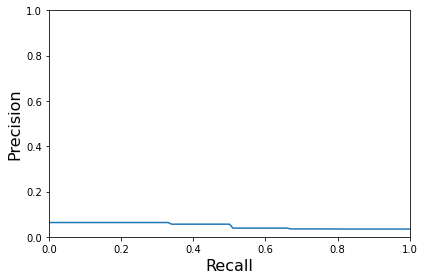

5444/5444 [==============================] - 226s 41ms/step - loss: 0.5065 - accuracy: 0.7558
Epoch 19/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7501
Epoch 00019: saving model to ../checkpoints/doublelstmcheckpoint1.h5


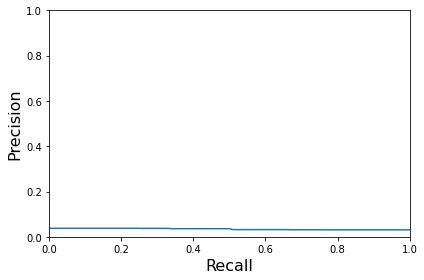

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5132 - accuracy: 0.7501
Epoch 20/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7567
Epoch 00020: saving model to ../checkpoints/doublelstmcheckpoint1.h5


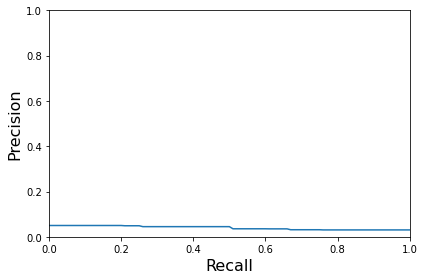

5444/5444 [==============================] - 227s 42ms/step - loss: 0.5014 - accuracy: 0.7567
Epoch 21/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7596
Epoch 00021: saving model to ../checkpoints/doublelstmcheckpoint1.h5


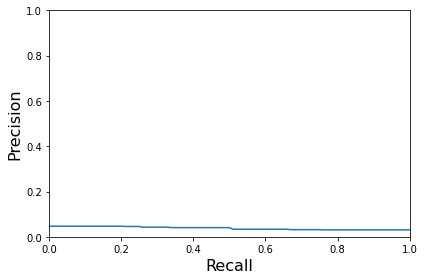

5444/5444 [==============================] - 226s 41ms/step - loss: 0.5015 - accuracy: 0.7596
Epoch 22/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.7592
Epoch 00022: saving model to ../checkpoints/doublelstmcheckpoint1.h5


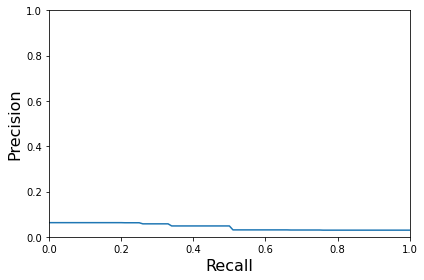

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5002 - accuracy: 0.7592
Epoch 23/50
5444/5444 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.7561
Epoch 00023: saving model to ../checkpoints/doublelstmcheckpoint1.h5


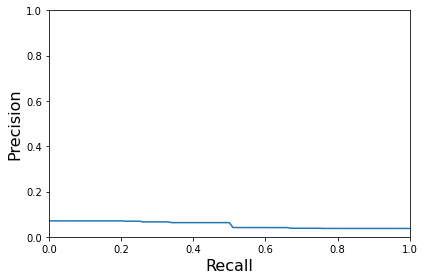

5444/5444 [==============================] - 225s 41ms/step - loss: 0.5069 - accuracy: 0.7561
Epoch 24/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7635
Epoch 00024: saving model to ../checkpoints/doublelstmcheckpoint1.h5


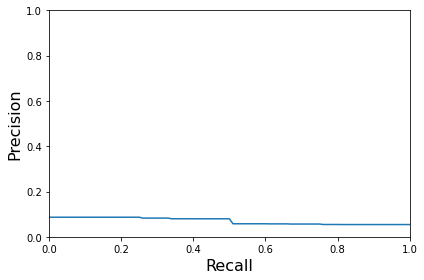

5444/5444 [==============================] - 225s 41ms/step - loss: 0.4951 - accuracy: 0.7636
Epoch 25/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7655
Epoch 00025: saving model to ../checkpoints/doublelstmcheckpoint1.h5


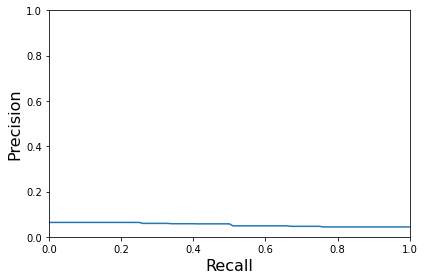

5444/5444 [==============================] - 226s 41ms/step - loss: 0.4998 - accuracy: 0.7655
Epoch 26/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.5015 - accuracy: 0.7605
Epoch 00026: saving model to ../checkpoints/doublelstmcheckpoint1.h5


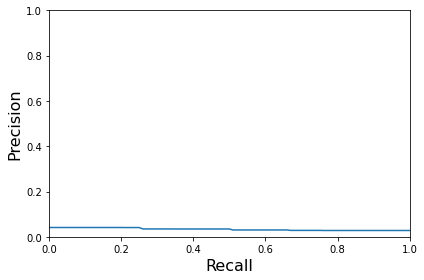

5444/5444 [==============================] - 226s 41ms/step - loss: 0.5014 - accuracy: 0.7605
Epoch 27/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7688
Epoch 00027: saving model to ../checkpoints/doublelstmcheckpoint1.h5


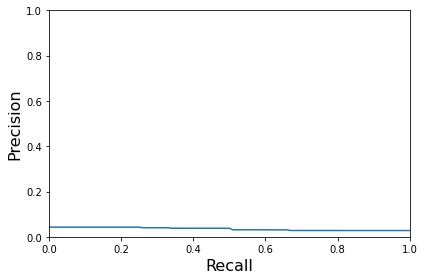

5444/5444 [==============================] - 224s 41ms/step - loss: 0.4891 - accuracy: 0.7688
Epoch 28/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4846 - accuracy: 0.7705
Epoch 00028: saving model to ../checkpoints/doublelstmcheckpoint1.h5


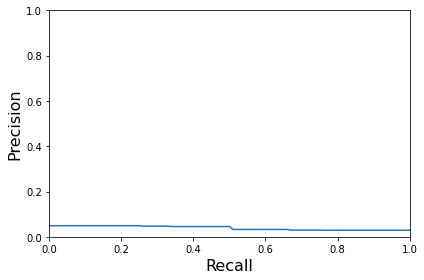

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4846 - accuracy: 0.7705
Epoch 29/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4905 - accuracy: 0.7678
Epoch 00029: saving model to ../checkpoints/doublelstmcheckpoint1.h5


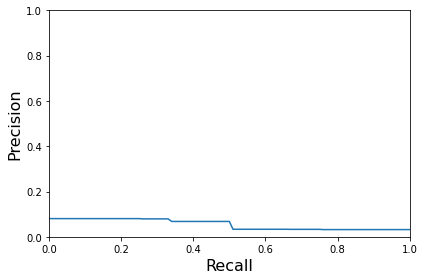

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4906 - accuracy: 0.7678
Epoch 30/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4861 - accuracy: 0.7703
Epoch 00030: saving model to ../checkpoints/doublelstmcheckpoint1.h5


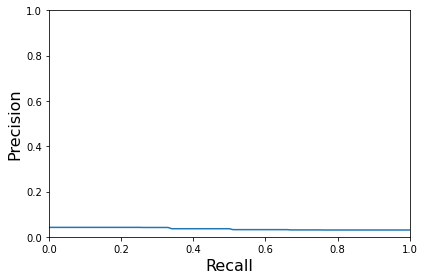

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4861 - accuracy: 0.7703
Epoch 31/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.7739
Epoch 00031: saving model to ../checkpoints/doublelstmcheckpoint1.h5


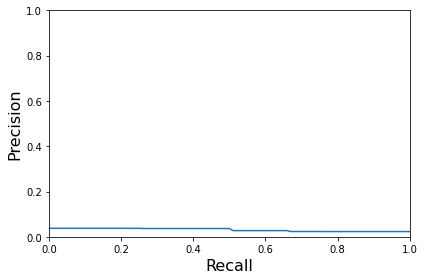

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4797 - accuracy: 0.7739
Epoch 32/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4840 - accuracy: 0.7731
Epoch 00032: saving model to ../checkpoints/doublelstmcheckpoint1.h5


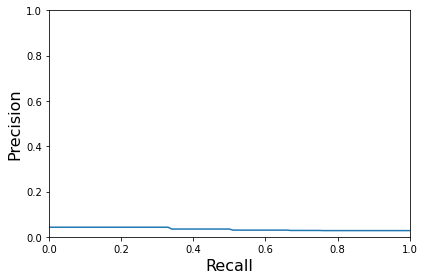

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4841 - accuracy: 0.7731
Epoch 33/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4793 - accuracy: 0.7773
Epoch 00033: saving model to ../checkpoints/doublelstmcheckpoint1.h5


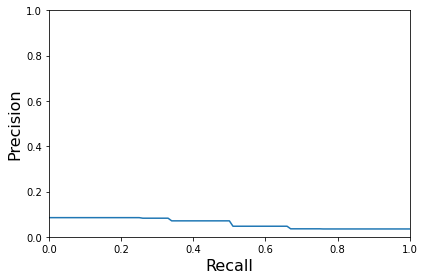

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4793 - accuracy: 0.7773
Epoch 34/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7794
Epoch 00034: saving model to ../checkpoints/doublelstmcheckpoint1.h5


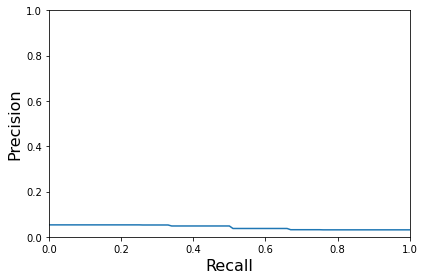

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4758 - accuracy: 0.7794
Epoch 35/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.7798
Epoch 00035: saving model to ../checkpoints/doublelstmcheckpoint1.h5


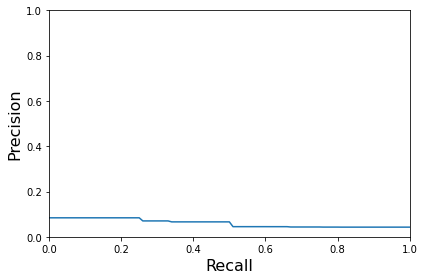

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4724 - accuracy: 0.7798
Epoch 36/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4706 - accuracy: 0.7806
Epoch 00036: saving model to ../checkpoints/doublelstmcheckpoint1.h5


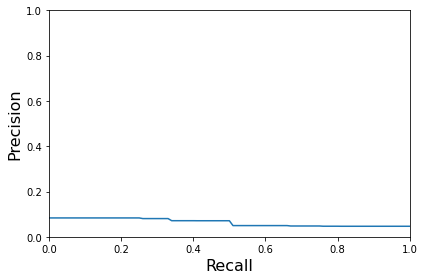

5444/5444 [==============================] - 228s 42ms/step - loss: 0.4705 - accuracy: 0.7806
Epoch 37/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.7795
Epoch 00037: saving model to ../checkpoints/doublelstmcheckpoint1.h5


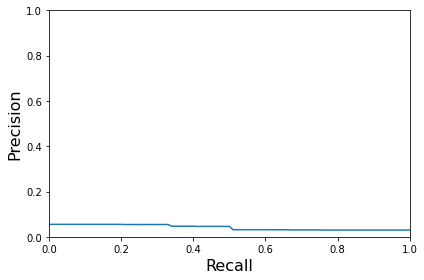

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4762 - accuracy: 0.7795
Epoch 38/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.7793
Epoch 00038: saving model to ../checkpoints/doublelstmcheckpoint1.h5


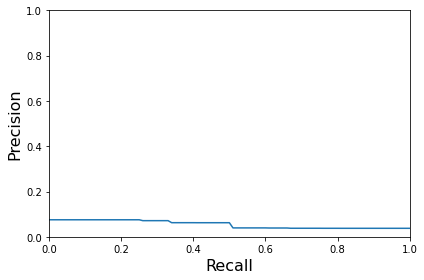

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4707 - accuracy: 0.7793
Epoch 39/50
5443/5444 [============================>.] - ETA: 0s - loss: 0.4711 - accuracy: 0.7803
Epoch 00039: saving model to ../checkpoints/doublelstmcheckpoint1.h5


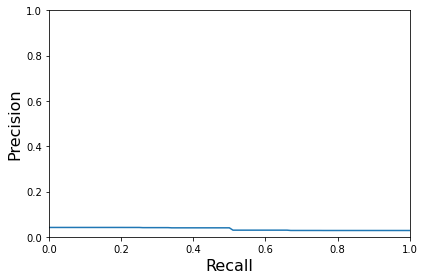

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4711 - accuracy: 0.7803
Epoch 40/50
5444/5444 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7878
Epoch 00040: saving model to ../checkpoints/doublelstmcheckpoint1.h5


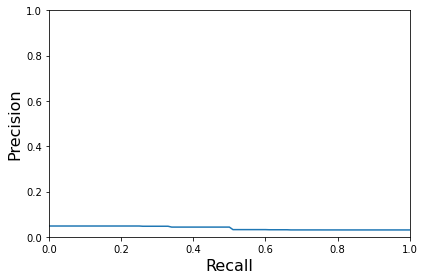

5444/5444 [==============================] - 227s 42ms/step - loss: 0.4634 - accuracy: 0.7878
Epoch 41/50
5376/5444 [============================>.] - ETA: 2s - loss: 0.4703 - accuracy: 0.7842

In [ ]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=5444, callbacks=[cp_callback, prc_callback])

  0/200 [..............................] - 0s 0s/step


UnboundLocalError: local variable 'batch_outputs' referenced before assignment